# Install Packages

In [29]:
%pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
%pip install cv2
%pip install pandas
%pip install seaborn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install albumentations
%pip install scipy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load Data

In [1]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album

from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

c:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
imgs_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data\imgs"
positions_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data\positions"

In [3]:
# 11408 dataset
imgs = np.load(rf'{imgs_dir}\11408_crop.nd2.npy') 
ava = np.load(rf"{positions_dir}\AVA_11408.mat.npy")
avb = np.load(rf"{positions_dir}\AVB_11408.mat.npy")

In [4]:
# 11409 dataset
imgs2 = np.load(rf'{imgs_dir}\11409_crop.nd2.npy') 
ava2 = np.load(rf"{positions_dir}\AVA_11409.mat.npy")
avb2 = np.load(rf"{positions_dir}\AVB_11409.mat.npy")

# Get Coordinates

In [5]:
def find_centroids(segmented_img):
  centroids = []
  cont, hierarchy = cv2.findContours(segmented_img, 
                          cv2.RETR_EXTERNAL, 
                          cv2.CHAIN_APPROX_SIMPLE)
  for c in cont:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))
  
  return centroids

In [6]:
def get_dist_score(x, y, x2, y2):
  return ((x2-x)**2)+((y2-y)**2)

# Prepare Data

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [8]:
# dataset definition
class CaImagesDataset(Dataset):
    # load the dataset
    def __init__(self, x, y):
        # store the inputs and outputs
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    # number of rows in the dataset
    def __len__(self):
        return len(self.x)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_data_scaler(data, opt):
  if (opt == "minmax"):
    print("minmax")
    scaler = MinMaxScaler(feature_range=(0,1))
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  elif (opt == "stand"):
    print("stand")
    scaler = StandardScaler()
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  return scaler, norm_data

def scale_data(data, full:int):
  norm_data = [i/full for i in data]
  return norm_data

# Train Model

In [10]:
#neural network
num = 0
torch.manual_seed(num)
random.seed(num)
np.random.seed(num)

## Predict X

In [11]:
h, w = imgs.shape[2:]
h2, w2 = imgs2.shape[2:]
height, width = max(h, h2), max(w, w2)
height, width

(546, 377)

In [12]:
xs = [x for (x, y) in ava]

stand
minmax


(array([ 91.,  83., 313., 364., 736., 461., 344.,  88.,  43.,  48.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

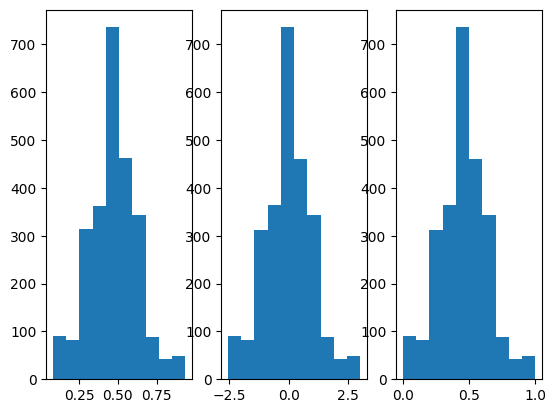

In [13]:
fig, ax=plt.subplots(1, 3)
ax[0].hist(scale_data(xs, full=width))
ax[1].hist(scale_data_scaler(xs, opt="stand" )[1])
ax[2].hist(scale_data_scaler(xs, opt="minmax")[1])
# the x axis scales are different

stand
minmax


(array([ 24.,  16.,  13.,  49., 327., 424., 470., 487., 544., 217.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

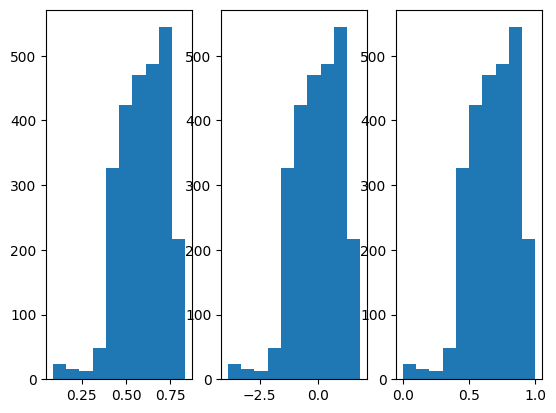

In [14]:
fig, ax=plt.subplots(1, 3)
ys = [y for (x, y) in ava]
ax[0].hist(scale_data(ys, full=height))
ax[1].hist(scale_data_scaler(ys, opt="stand")[1])
ax[2].hist(scale_data_scaler(ys, opt="minmax")[1])

In [105]:
def get_features_and_outcome(num_prev, neuron_positions, width, height):
  i = 0
  features_x = []
  features_y = []

  # Scale data
  norm_neuron_positions_x = scale_data([x for (x, y) in neuron_positions], full=width)
  norm_neuron_positions_y = scale_data([y for (x, y) in neuron_positions], full=height)

  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    # each loop = one "set" of data + previous points. We have data points for the 10th frame to the last frame (2570th)
    features_x.append(norm_neuron_positions_x[i:i+num_prev])
    features_y.append(norm_neuron_positions_y[i:i+num_prev])
    i+=1

  # make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': norm_neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': norm_neuron_positions_y[num_prev:], 'curr_frame': [i for i in range(num_prev, len(neuron_positions))]
          } 
  df = pd.DataFrame(dict)
  return df

In [110]:
df1 = get_features_and_outcome(10, ava,width, height)
df2 = get_features_and_outcome(10, ava2,width, height)
df = pd.concat([df1, df2])
df1

,prev_n_x,curr_x,prev_n_y,curr_y,curr_frame
0,"[0.3103448275862069, 0.3132183908045976, 0.311...",0.420424,"[0.16941391941391942, 0.16056166056166057, 0.1...",0.089337,10
1,"[0.3132183908045976, 0.3116710875331565, 0.318...",0.435978,"[0.16056166056166057, 0.1510989010989011, 0.14...",0.086247,11
2,"[0.3116710875331565, 0.3183023872679045, 0.331...",0.446950,"[0.1510989010989011, 0.14194139194139194, 0.13...",0.084772,12
3,"[0.3183023872679045, 0.33118605532398643, 0.34...",0.457326,"[0.14194139194139194, 0.1311704168847026, 0.12...",0.089528,13
4,"[0.33118605532398643, 0.34530986255124185, 0.3...",0.466006,"[0.1311704168847026, 0.12037962037962037, 0.11...",0.101504,14
...,...,...,...,...,...
2556,"[0.35013262599469497, 0.3511273209549072, 0.35...",0.354869,"[0.5497323189630882, 0.5484203296703297, 0.548...",0.546965,2566
2557,"[0.3511273209549072, 0.35381668140288836, 0.35...",0.353204,"[0.5484203296703297, 0.5482295482295482, 0.550...",0.550414,2567
2558,"[0.35381668140288836, 0.3551724137931034, 0.35...",0.350289,"[0.5482295482295482, 0.5500915750915751, 0.549...",0.553868,2568
2559,"[0.3551724137931034, 0.35610079575596815, 0.35...",0.345440,"[0.5500915750915751, 0.5497252747252747, 0.548...",0.554663,2569


In [107]:
import math
X = np.array(df.prev_n_x.tolist())
Y = np.array(df.curr_x.tolist())
split = math.floor(len(df)*0.8)
x_train = X[:split]
x_test = X[split:]
y_train = Y[:split]
y_test = Y[split:]

In [109]:
df.curr_frame[split:] # Check which images are in test set

1611    1621
1612    1622
1613    1623
1614    1624
1615    1625
        ... 
2649    2659
2650    2660
2651    2661
2652    2662
2653    2663
Name: curr_frame, Length: 1043, dtype: int64

In [108]:
from torch.utils.data import DataLoader 
train_set = CaImagesDataset(x_train,y_train)
train_loader = DataLoader(train_set,
                          shuffle=True,
                          batch_size=256 # Each batch has 256 samples. Since dataset has 2048 samples total, there are 8 training batches.
                          )

In [21]:
torch.manual_seed(0)

In [22]:
#neural network
from torch import nn

class neural_network(nn.Module):
    def __init__(self):
        super(neural_network,self).__init__()
        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size=5,
                            num_layers=1,
                            batch_first=True
                            )
        self.fc1 = nn.Linear(in_features=5,
                             out_features=1)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

model = neural_network()

In [23]:
# optimizer , loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 500

In [24]:
existing_epochs=0

In [25]:
train_times = {} #key= epoch, value=loss for that epoch

In [26]:
#training loop
for i in range(801):
    for j,data in  enumerate(train_loader):
        y_pred = model(data[:][0].view(-1,10,1)).reshape(-1)
        loss = criterion(y_pred,data[:][1])
        loss.backward()
        optimizer.step()
    existing_epochs+=1
    train_times[existing_epochs] = loss
    if i%50 == 0:
        print(existing_epochs,"th iteration : ",loss)

1 th iteration :  tensor(0.2627, grad_fn=<MseLossBackward0>)
51 th iteration :  tensor(0.1248, grad_fn=<MseLossBackward0>)
101 th iteration :  tensor(0.0473, grad_fn=<MseLossBackward0>)
151 th iteration :  tensor(0.0274, grad_fn=<MseLossBackward0>)
201 th iteration :  tensor(0.0220, grad_fn=<MseLossBackward0>)
251 th iteration :  tensor(0.0114, grad_fn=<MseLossBackward0>)
301 th iteration :  tensor(0.0083, grad_fn=<MseLossBackward0>)
351 th iteration :  tensor(0.0017, grad_fn=<MseLossBackward0>)
401 th iteration :  tensor(0.0009, grad_fn=<MseLossBackward0>)
451 th iteration :  tensor(0.0041, grad_fn=<MseLossBackward0>)
501 th iteration :  tensor(0.0031, grad_fn=<MseLossBackward0>)
551 th iteration :  tensor(0.0011, grad_fn=<MseLossBackward0>)
601 th iteration :  tensor(0.0007, grad_fn=<MseLossBackward0>)
651 th iteration :  tensor(0.0007, grad_fn=<MseLossBackward0>)
701 th iteration :  tensor(0.0004, grad_fn=<MseLossBackward0>)
751 th iteration :  tensor(0.0004, grad_fn=<MseLossBackwar

In [27]:
losses = [tsr.detach().numpy().flat[0] for tsr in train_times.values()]

Text(0.5, 1.0, 'Train Loss Curve')

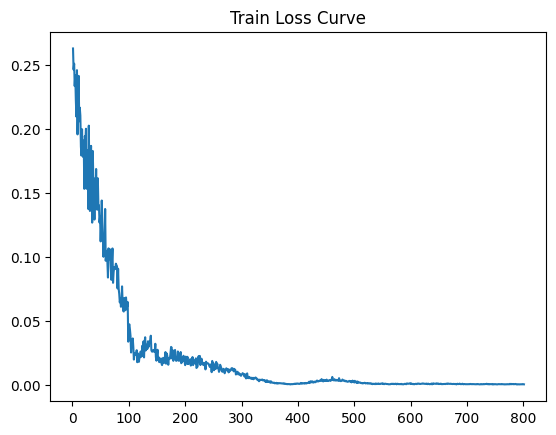

In [28]:
plt.plot(train_times.keys(), losses)
plt.title("Train Loss Curve")

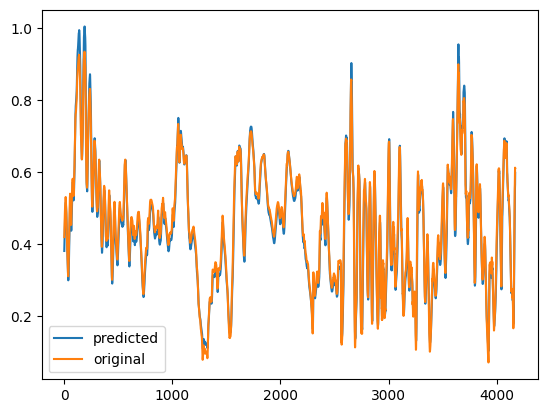

In [29]:
#training set actual vs predicted
train_pred = model(train_set[:][0].view(-1,10,1)).view(-1)
plt.plot(train_pred.detach().numpy(),label='predicted')
plt.plot(train_set[:][1].view(-1),label='original')
plt.legend()

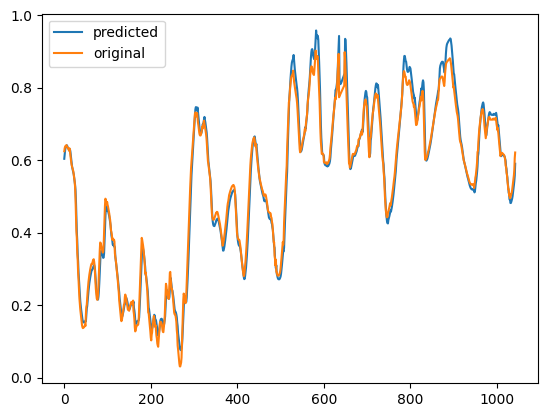

In [30]:
#test set actual vs predicted
test_set = CaImagesDataset(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()

## Predict Y

In [31]:
height
print(imgs.shape[2:])
print(imgs2.shape[2:])

(484, 377)
(546, 340)


In [32]:
#neural network
num = 24
torch.manual_seed(num)
random.seed(num)
np.random.seed(num)

In [33]:
from sklearn.preprocessing import StandardScaler

def get_features_and_outcome_y(num_prev, neuron_positions):
  i = 0
  features_y = []
  norm_features_y = []
  norm_neuron_positions_y = scale_data([y for (x, y) in neuron_positions], height)

  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    # each loop = one "set" of data + previous points. We have data points for the 10th frame to the last frame (2570th)
    features_y.append(norm_neuron_positions_y[i:i+num_prev])
    i+=1

  # make dataframe with features and outcome variables
  dict = {'prev_n_y': features_y, 'curr_y': norm_neuron_positions_y[num_prev:]} 
  df = pd.DataFrame(dict)
  return df

In [34]:
dfy1 = get_features_and_outcome_y(10, ava)
dfy2 = get_features_and_outcome_y(10, ava2)
dfy = pd.concat([dfy1, dfy2])
dfy

,prev_n_y,curr_y
0,"[0.16941391941391942, 0.16056166056166057, 0.1...",0.089337
1,"[0.16056166056166057, 0.1510989010989011, 0.14...",0.086247
2,"[0.1510989010989011, 0.14194139194139194, 0.13...",0.084772
3,"[0.14194139194139194, 0.1311704168847026, 0.12...",0.089528
4,"[0.1311704168847026, 0.12037962037962037, 0.11...",0.101504
...,...,...
2649,"[0.38461538461538464, 0.36536111515416125, 0.3...",0.276557
2650,"[0.36536111515416125, 0.35494505494505496, 0.3...",0.270016
2651,"[0.35494505494505496, 0.3424908424908425, 0.32...",0.263533
2652,"[0.3424908424908425, 0.32936507936507936, 0.31...",0.256090


In [35]:
import math

X2 = np.array(dfy.prev_n_y.tolist())
Y2 = np.array(dfy.curr_y.tolist())
split = math.floor(len(dfy)*0.8)
x_train2 = X2[:split]
x_test2 = X2[split:]
y_train2 = Y2[:split]
y_test2 = Y2[split:]

In [36]:
from torch.utils.data import DataLoader 
train_set2 = CaImagesDataset(x_train2,y_train2)
train_loader2 = DataLoader(train_set2,
                          shuffle=True,
                          batch_size=256 # Each batch has 256 samples. Since dataset has 2048 samples total, there are 8 training batches.
                          )

In [37]:
model2 = neural_network()

In [38]:
# optimizer , loss
criterion2 = torch.nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.0001)
epochs = 2000

In [39]:
existing_epochs2=0
train_times2 = {}

In [40]:
# # update optimizer learning rates
# for g in optimizer2.param_groups:
#     g['lr'] = 0.001

In [41]:
#training loop
for i in range(epochs+1):
    for j,data in enumerate(train_loader2):
        y_pred = model2(data[:][0].view(-1,10,1)).reshape(-1)
        loss2 = criterion2(y_pred,data[:][1])
        loss2.backward()
        optimizer2.step()
    existing_epochs2+=1
    train_times2[existing_epochs2]=loss2
    if i%50 == 0:
        print(existing_epochs2,"th iteration : ",loss2)

1 th iteration :  tensor(0.4576, grad_fn=<MseLossBackward0>)
51 th iteration :  tensor(0.0224, grad_fn=<MseLossBackward0>)
101 th iteration :  tensor(0.0619, grad_fn=<MseLossBackward0>)
151 th iteration :  tensor(0.0173, grad_fn=<MseLossBackward0>)
201 th iteration :  tensor(0.0190, grad_fn=<MseLossBackward0>)
251 th iteration :  tensor(0.0210, grad_fn=<MseLossBackward0>)
301 th iteration :  tensor(0.0211, grad_fn=<MseLossBackward0>)
351 th iteration :  tensor(0.0241, grad_fn=<MseLossBackward0>)
401 th iteration :  tensor(0.0164, grad_fn=<MseLossBackward0>)
451 th iteration :  tensor(0.0150, grad_fn=<MseLossBackward0>)
501 th iteration :  tensor(0.0171, grad_fn=<MseLossBackward0>)
551 th iteration :  tensor(0.0205, grad_fn=<MseLossBackward0>)
601 th iteration :  tensor(0.0187, grad_fn=<MseLossBackward0>)
651 th iteration :  tensor(0.0210, grad_fn=<MseLossBackward0>)
701 th iteration :  tensor(0.0152, grad_fn=<MseLossBackward0>)
751 th iteration :  tensor(0.0122, grad_fn=<MseLossBackwar

In [42]:
losses2 = [tsr.detach().numpy().flat[0] for tsr in train_times2.values()]

Text(0.5, 1.0, 'Train Loss Curve')

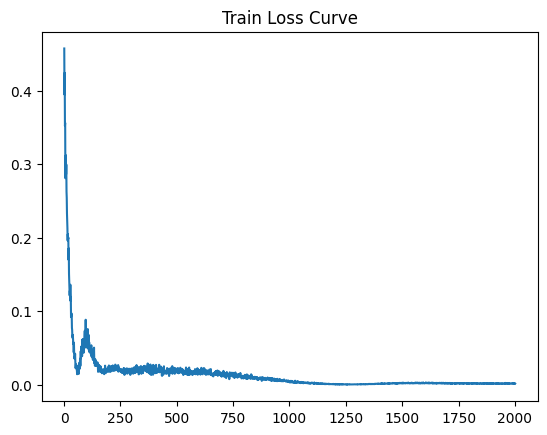

In [43]:
plt.plot(train_times2.keys(), losses2)
plt.title("Train Loss Curve")

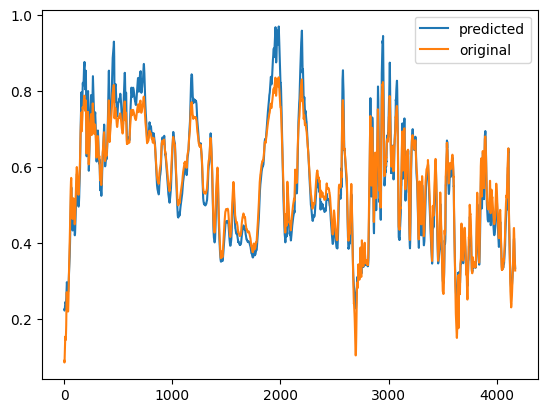

In [44]:
#test set actual vs predicted
train_set2 = CaImagesDataset(x_train2,y_train2)
train_pred2 = model2(train_set2[:][0].view(-1,10,1)).view(-1)
plt.plot(train_pred2.detach().numpy(),label='predicted')
plt.plot(train_set2[:][1].view(-1),label='original')
plt.legend()

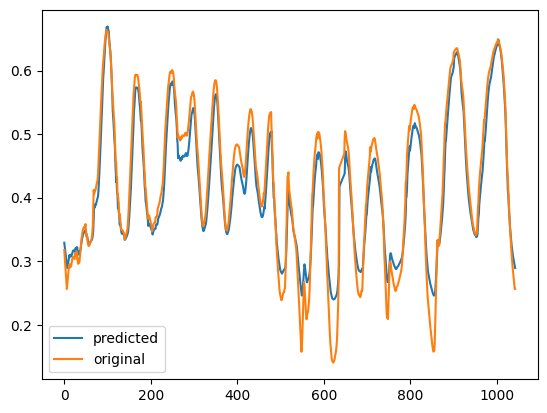

In [45]:
#test set actual vs predicted
test_set2 = CaImagesDataset(x_test2,y_test2)
test_pred2 = model2(test_set2[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred2.detach().numpy(),label='predicted')
plt.plot(test_set2[:][1].view(-1),label='original')
plt.legend()

In [95]:
len(test_set), len(train_set)

(1043, 4172)

In [97]:
len(imgs), len(imgs2)

(2571, 2664)

# Test Model

In [86]:
def unscale_data(data, full:int):
  try:
      norm_data = [i*full for i in data]
  except:
      norm_data = data*full
  return np.array(norm_data)

In [113]:
len(train_set), len(test_set)
df.curr_frame[split:]

1611    1621
1612    1622
1613    1623
1614    1624
1615    1625
        ... 
2649    2659
2650    2660
2651    2661
2652    2662
2653    2663
Name: curr_frame, Length: 1043, dtype: int64

In [91]:
# inputx = scaler.transform(np.array([x for (x, y) in ava][:10]).reshape((-1, 1)))
# inputy = scaler2.transform(np.array([y for (x, y) in ava][:10]).reshape((-1, 1)))
inputx = np.array(scale_data([x for (x, y) in ava][:10], width)).reshape((-1, 1))
inputy = np.array(scale_data([y for (x, y) in ava][:10], height)).reshape((-1, 1))
inputx, inputy

(array([[0.31034483],
        [0.31321839],
        [0.31167109],
        [0.31830239],
        [0.33118606],
        [0.34530986],
        [0.36062738],
        [0.37559682],
        [0.39098143],
        [0.40659341]]),
 array([[0.16941392],
        [0.16056166],
        [0.1510989 ],
        [0.14194139],
        [0.13117042],
        [0.12037962],
        [0.11219939],
        [0.10512821],
        [0.0996337 ],
        [0.09432234]]))

In [115]:
width

377

In [130]:
def get_closest_cent(centroids:List, pred:Tuple):
    """ Returns the closest centroid to the predicted coordinates"""
    max_score = 10**1000
    predx, predy = pred
    coords = (0,0) # Closest to predicted coords

    for (pot_x, pot_y) in centroids:
        score = get_dist_score(predx, predy, pot_x, pot_y)
        print(f"Centroid: {pot_x}, {pot_y} | Score: {round(score)}")
        if score <= max_score:
            max_score = score
        coords = (pot_x, pot_y)
    return coords

In [136]:
import time
start_time = time.time() 

n_input=10 # number of previous frames to use as features
num_correct = 0 # number of correct predictions
num_wrong = 0 # number of wrong predictions
frame_reset_pts = {} # dictionary of frames to reset at (key: frame, value: predicted (x, y) coordinates)
streak_dct = {} # dictionary of streaks (key: frame, value: streak count)
streak_count = 0

# Dictionaries for plotting
centroid_dct = {} # key: frame, value: list of centroids
pred_dct = {} # key: frame, value: (predx, predy)
chosen_path = {} # key: frame, value: selected (x, y) coordinates

for i in range(0, 201):
  print(f"frame {i+n_input}")

  # features
  x_init = torch.from_numpy(np.float32(np.expand_dims(inputx[i:i+n_input].reshape(-1, 1), 0))) # these are normalized values
  y_init = torch.from_numpy(np.float32(np.expand_dims(inputy[i:i+n_input].reshape(-1, 1), 0))) # these are standardized values
  print(x_init, y_init)
  
  # predicted coordinates
  predx = unscale_data(model(x_init).detach().numpy()[0][0], full=width)
  predy = unscale_data(model(y_init).detach().numpy()[0][0], full=height)
  pred_dct[i]=(predx, predy)

  # actual coordinates
  actx, acty = ava[i+n_input] 

  # Get list of centroids
  ground_truth_dir=r'C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\11408'
  mask = cv2.imread(f"{ground_truth_dir}/{i+n_input}.png", cv2.IMREAD_GRAYSCALE)
  centroids = find_centroids(mask)  # list of potential centroids
  centroid_dct[i] = centroids

  # Find closest centroid
  max_score = 10**1000
  max_act_score = 10**10000
  coords = (0,0) # Closest to predicted coords
  coords_act = (0,0) # Closest to actual coords

  for (pot_x, pot_y) in centroids:
    score = get_dist_score(predx, predy, pot_x, pot_y)
    act_score = get_dist_score(actx, acty, pot_x, pot_y)
    print(f"Centroid: {pot_x}, {pot_y} | Score: {round(score)}")
    if score <= max_score:
      max_score = score
      coords = (pot_x, pot_y)
    if act_score <= max_act_score:
      max_act_score = score
      coords_act = (pot_x, pot_y)

  print(f"Original Prediction: {'%.2f'%(predx)}, {'%.2f'%(predy)}")
  print(f"Actual Coords: {'%.2f'%(actx)}, {'%.2f'%(acty)}")
  print(f"Closest to Pred Coords: {coords[0]}, {coords[1]}") # last element = most recently appended "curr"
  print(f"Closest to Actual Coords: {coords_act[0]}, {coords_act[1]}") # last element = most recently appended "curr"


  # prediction is correct if closest centroid to predicted coords is the same as closest centroid to actual coords
  if (coords[0] == coords_act[0]):
    print("Correct")
    num_correct +=1
    inputx = np.append(inputx, unscale_data(np.array(coords[0]).reshape(-1, 1)[0][0], width)) 
    inputy = np.append(inputy,  unscale_data(np.array(coords[1]).reshape(-1, 1)[0][0], height))
    streak_count+=1
  else:
    print("False")
    num_wrong +=1
    frame_reset_pts[i+n_input] = (predx, predy)
    actual_norm_x = scale_data(ava[i+n_input][0].reshape(-1, 1), width)
    actual_norm_y = scale_data(ava[i+n_input][1].reshape(-1, 1), height)
    inputx = np.append(inputx, actual_norm_x) 
    inputy = np.append(inputy, actual_norm_y)
    streak_dct[i]=streak_count
    streak_count=0
  chosen_path[i] = (coords[0], coords[1])
  print(f"{num_correct}, {num_wrong}")
  print("\n")
print(f"Time: {time.time() -start_time}")

frame 10
tensor([[[0.3103],
         [0.3132],
         [0.3117],
         [0.3183],
         [0.3312],
         [0.3453],
         [0.3606],
         [0.3756],
         [0.3910],
         [0.4066]]]) tensor([[[0.1694],
         [0.1606],
         [0.1511],
         [0.1419],
         [0.1312],
         [0.1204],
         [0.1122],
         [0.1051],
         [0.0996],
         [0.0943]]])
Centroid: 138, 93 | Score: 759
Centroid: 147, 87 | Score: 446
Centroid: 141, 54 | Score: 155
Centroid: 156, 48 | Score: 472
Original Prediction: 143.98, 66.10
Actual Coords: 158.50, 48.78
Closest to Pred Coords: 141, 54
Closest to Actual Coords: 156, 48
False
0, 1


frame 11
tensor([[[0.3132],
         [0.3117],
         [0.3183],
         [0.3312],
         [0.3453],
         [0.3606],
         [0.3756],
         [0.3910],
         [0.4066],
         [0.4204]]]) tensor([[[0.1606],
         [0.1511],
         [0.1419],
         [0.1312],
         [0.1204],
         [0.1122],
         [0.1051],
      

In [ ]:
frame=20
#TODO: Bug for negative positions --> y coord in test dataset that's even smaller than the one in normal dataset
# Normalize based on image length?
markersize=4

for frame in range(0, 201):
  plt.figure(figsize=(10, 30))
  plt.imshow(imgs[frame+10, 0, :, :])
  frame_coords = centroid_dct[frame]
  print(pred_dct[10])

  closest_coord = get_closest_cent(frame_coords, pred_dct[frame])
  for (x, y) in frame_coords:
    if x == closest_coord[0] and y == closest_coord[1]:
      colour = "blue"
    else:
      colour = "red"
    plt.plot(x, y, marker="o", markersize=markersize, markeredgecolor=colour, markerfacecolor=colour, label="centroids")
  plt.plot(pred_dct[frame][0], pred_dct[frame][1], marker="o", markersize=markersize, markeredgecolor="yellow", markerfacecolor="yellow", label="predicted")
  plt.plot(chosen_path[frame][0], chosen_path[frame][1], marker="o", markersize=markersize, markeredgecolor="yellow", markerfacecolor="yellow", label="predicted")
  plt.plot(ava[frame+10][0], ava[frame+10][1], marker="o", markersize=markersize, markeredgecolor="green", markerfacecolor="green", label="actual")
  # plt.savefig(f"/content/gdrive/MyDrive/saves/{frame}.png")
  plt.legend(loc="lower right")
  plt.savefig(rf'C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\{frame}.png')
  print(f"Saved {frame}.png")